In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# EDA

## 1.	Load the Titanic dataset using Python's pandas library.

In [4]:
df_train=pd.read_csv('Titanic_train.csv')
df_test=pd.read_csv('Titanic_test.csv')

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2.Check for missing value

In [7]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## 3. Explore the data distribution using histogram and boxplot

In [10]:
# we have to separate numerical columns for histogram

In [11]:
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

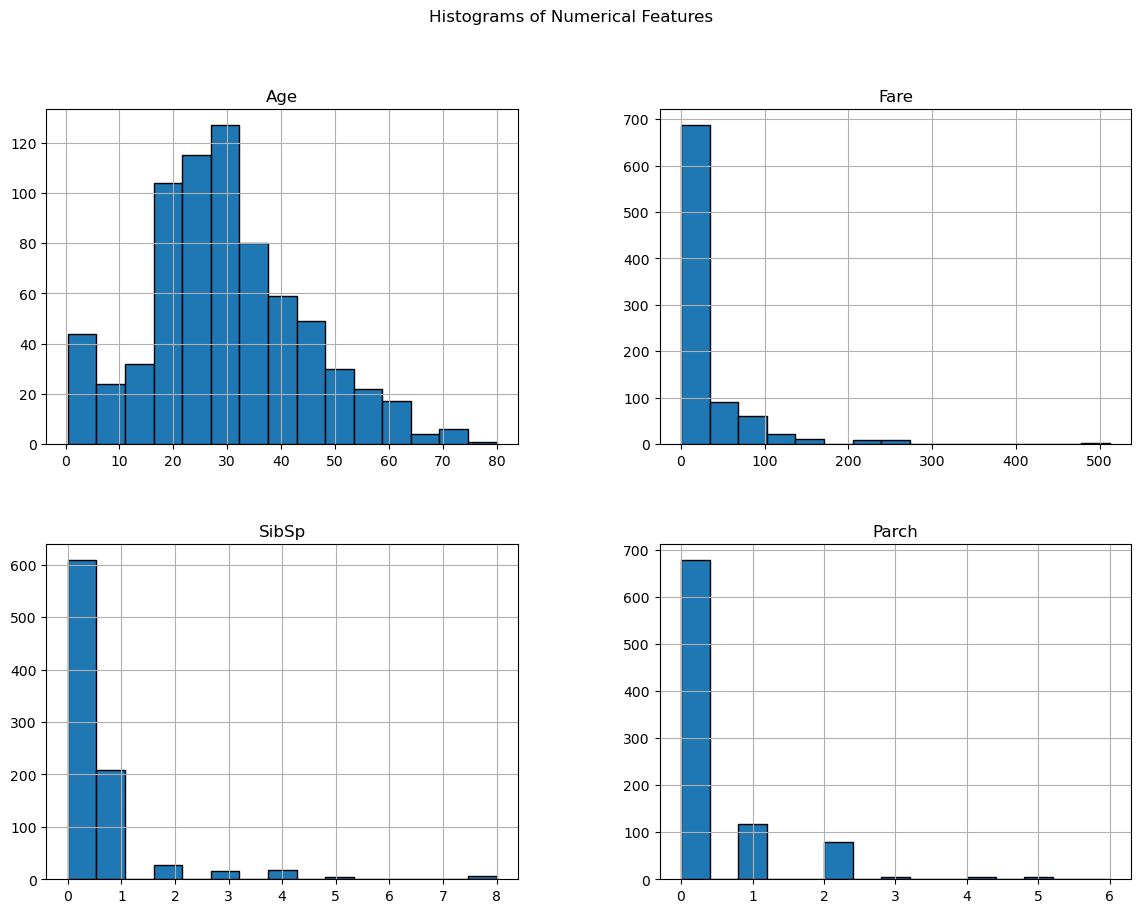

In [12]:
# Plot histograms
df_train[numerical_features].hist(bins=15, figsize=(14, 10),edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

In [13]:
# Boxplot

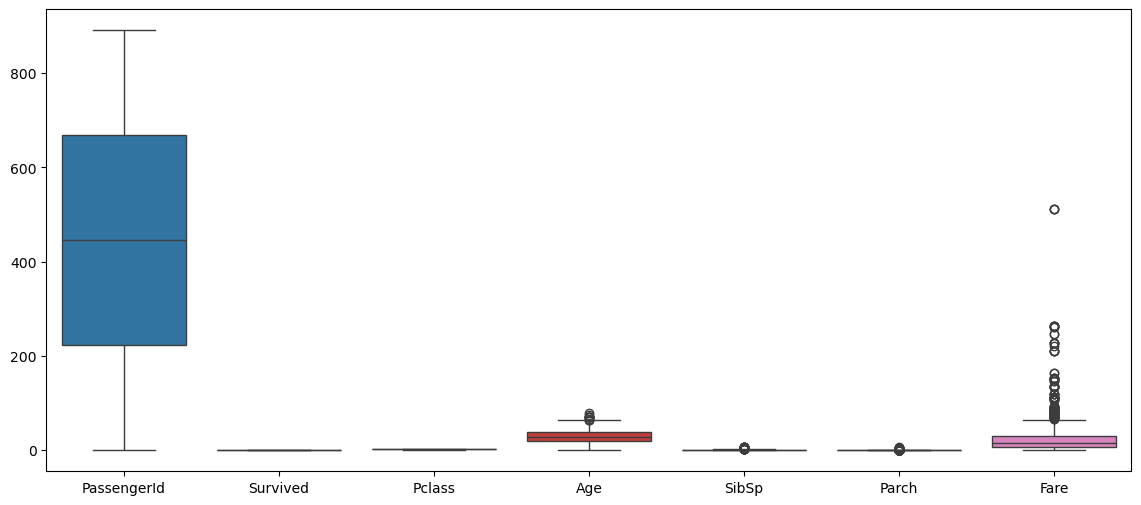

In [14]:
# Box plots for features with respect to survival
plt.figure(figsize=(14, 6))
sns.boxplot (data=df_train)
plt.show()

## 4.Visualize relationships between features and survival using scatter plots and bar plots.

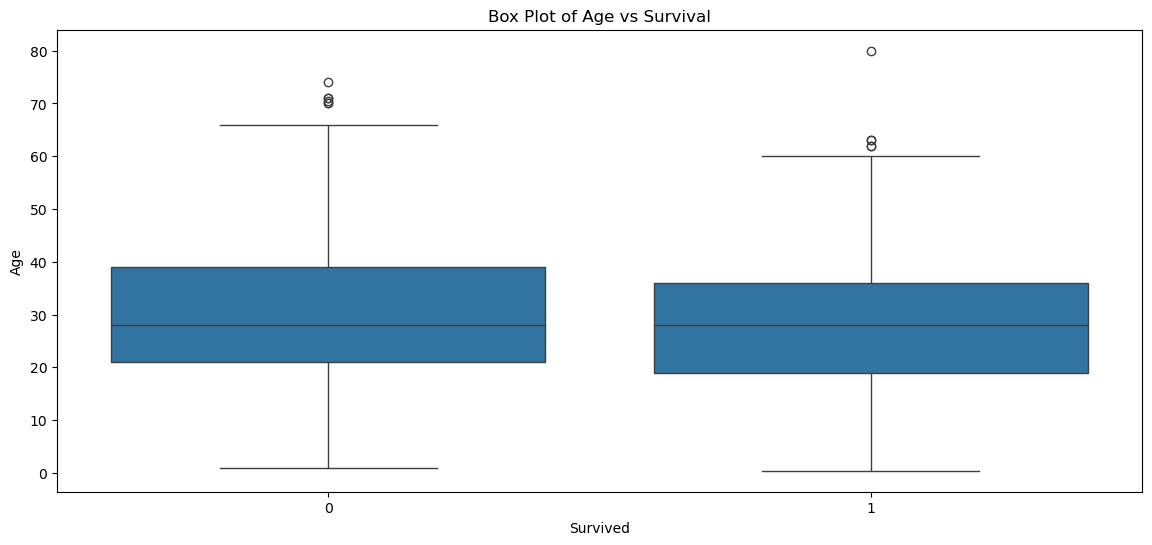

In [23]:
# Box plots for features with respect to survival
plt.figure(figsize=(14, 6))
sns.boxplot(x='Survived', y='Age', data=df_train)
plt.title("Box Plot of Age vs Survival")
plt.show()

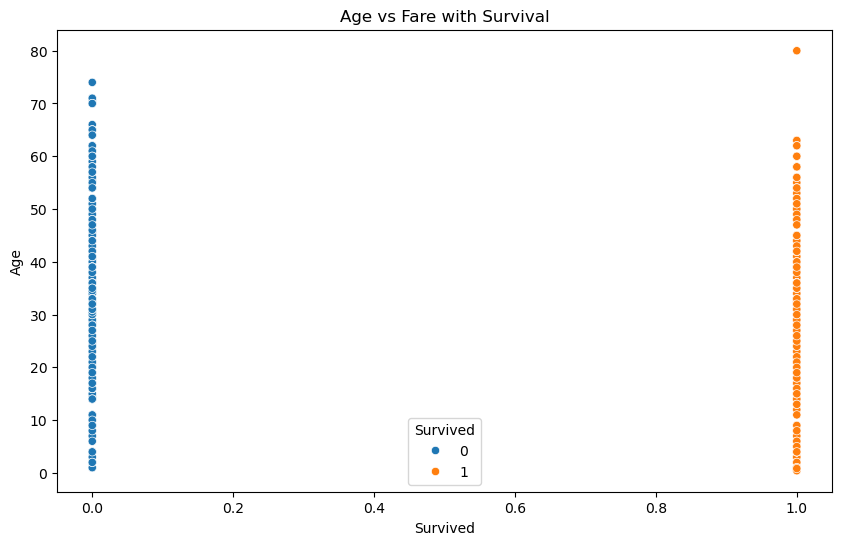

In [24]:
# Scatter plot of Survived vs Age, color-coded by survival
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Survived', y='Age', hue='Survived', data=df_train)
plt.title("Age vs Fare with Survival")
plt.show()

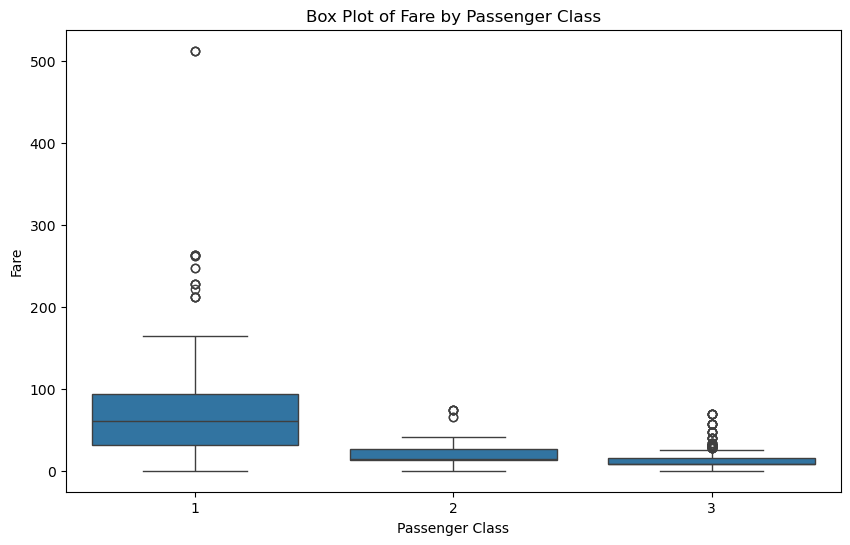

In [25]:
# Additional Boxplot
# Box plot for 'Fare' by 'Pclass' to understand how ticket class relates to fare distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Fare', data=df_train)
plt.title("Box Plot of Fare by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Fare")
plt.show()

# Data Preprocessing

## 1. Impute missing values

In [34]:
# filling missing values from age column with median.

df_train['Age'].fillna(df_train['Age'].median(), inplace=True)

In [36]:
# filling missing values from age column with mode.
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace=True)

In [38]:
# Since 'Cabin' has a large number of missing values, we may either drop it or impute with 'Unknown'
# Here we replace missing values with 'Unknown'

df_train['Cabin'].fillna('Unknown', inplace=True)

In [40]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## 2.Encode categorical variables using one-hot encoding or label encoding

In [43]:
# One-hot encode categorical variables
df_train = pd.get_dummies(df_train, columns=['Sex', 'Embarked'], drop_first=True)
df_train

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Unknown,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Unknown,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Unknown,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,Unknown,True,False,True
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,False,False,True
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",28.0,1,2,W./C. 6607,23.4500,Unknown,False,False,True
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,True,False,False


In [45]:
# Drop irrelevant columns (e.g., Name, Ticket, Cabin) for simplicity

df_train.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

## 3.If needed you can apply more preprocessing methods on the given dataset.


In [50]:
# we will use standard scaler for scaling data 

In [52]:
scaler= StandardScaler()

In [56]:
# Apply scaling to the 'Age' and 'Fare' columns
df_train[['Age', 'Fare']] = scaler.fit_transform(df_train[['Age', 'Fare']])

In [58]:
df_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,-0.565736,1,0,-0.502445,True,False,True
1,2,1,1,0.663861,1,0,0.786845,False,False,False
2,3,1,3,-0.258337,0,0,-0.488854,False,False,True
3,4,1,1,0.433312,1,0,0.420730,False,False,True
4,5,0,3,0.433312,0,0,-0.486337,True,False,True
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,-0.181487,0,0,-0.386671,True,False,True
887,888,1,1,-0.796286,0,0,-0.044381,False,False,True
888,889,0,3,-0.104637,1,2,-0.176263,False,False,True
889,890,1,1,-0.258337,0,0,-0.044381,True,False,False


# Building Predictive Models

In [64]:
# Split the preprocessed dataset into training and testing sets.

In [72]:
# Split the data into features and target variable.

features=df_train.drop(columns='Survived')
target=df_train['Survived']

In [74]:
 # Split into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(features,target,train_size=0.80,random_state=50)

In [76]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(712, 9)
(179, 9)
(712,)
(179,)


In [ ]:
# 2.Choose appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score) for model evaluation.

In [130]:
# Define evaluation function
def evaluate(y_true, y_pred):
    return {"Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)}


In [78]:
# 3.Build predictive models using LightGBM and XGBoost algorithms.

## Lightbgm model

In [175]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100,max_depth=3,max_bins=100, random_state=50,boosting_type='goss')

In [177]:
lgb_model.fit(x_train, y_train)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 264, number of negative: 448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.52

LGBMClassifier(boosting_type='goss', max_bins=100, max_depth=3, random_state=50)

In [179]:
y_pred_lgb = lgb_model.predict(x_test)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [181]:
# we defined function for evaluating results
lgb_results = evaluate(y_test, y_pred_lgb)
lgb_results

{'Accuracy': 0.7877094972067039,
 'Precision': 0.7941176470588235,
 'Recall': 0.6923076923076923,
 'F1-Score': 0.7397260273972602}

In [173]:
print("LightGBM Results:", lgb_results)

LightGBM Results: {'Accuracy': 0.7821229050279329, 'Precision': 0.8095238095238095, 'Recall': 0.6538461538461539, 'F1-Score': 0.723404255319149}


## XGBoost Model

In [140]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [142]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xgb = xgb_model.predict(x_test)

In [126]:
xgb_results = evaluate(y_test, y_pred_xgb)
print("XGBoost Results:", xgb_results)

XGBoost Results: {'Accuracy': 0.7877094972067039, 'Precision': 0.8125, 'Recall': 0.6666666666666666, 'F1-Score': 0.7323943661971831}


## cross-validation and hyperparameter tuning to optimize model performance.

In [ ]:
# Grid Search

In [224]:
# finding best parameters for LightGBM.

In [157]:
lgb_params = {'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200] }

In [161]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='accuracy')
lgb_grid.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 211, number of negative: 358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370826 -> initscore=-0.528675
[LightGBM] [Info] Start training from score -0.528675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [-1, 10, 20], 'n_estimators': [100, 200],
                         'num_leaves': [31, 50]},
             scoring='accuracy')

In [183]:
# Best parameters for LightGBM
print("Best parameters for LightGBM:\n", lgb_grid.best_params_)

Best parameters for LightGBM:
 {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 31}


In [214]:
# Train LightGBM with best parameters and evaluate

best_lgb_model = lgb_grid.best_estimator_

In [216]:
y_pred_lgb = best_lgb_model.predict(x_test)

In [275]:
lgb_results = evaluate(y_test, y_pred_lgb)

In [222]:
print("Optimized LightGBM Results:", lgb_results)

Optimized LightGBM Results: {'Accuracy': 0.8044692737430168, 'Precision': 0.8412698412698413, 'Recall': 0.6794871794871795, 'F1-Score': 0.75177304964539}


In [ ]:
# finding best parameters for XGBoost

In [236]:
# Cross-validation and hyperparameter tuning for XGBoost

xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1,0.05, 0.01],
    'n_estimators': [50,100, 200],
    'subsample': [0.7,0.8,0.9, 1.0] }


In [238]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [240]:
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='accuracy')

In [242]:
xgb_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='accuracy')

In [246]:
# Best parameters for XGBoost
print("Best parameters for XGBoost:\n", xgb_grid.best_params_)

Best parameters for XGBoost:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}


In [248]:
# Train XGBoost with best parameters and evaluate
best_xgb_model = xgb_grid.best_estimator_

In [250]:
y_pred_xgb = best_xgb_model.predict(x_test)

In [273]:
xgb_results = evaluate(y_test, y_pred_xgb)

In [254]:
print("Optimized XGBoost Results: \n", xgb_results)

Optimized XGBoost Results: 
 {'Accuracy': 0.7877094972067039, 'Precision': 0.8333333333333334, 'Recall': 0.6410256410256411, 'F1-Score': 0.7246376811594203}


# Comparative Analysis

## 1.Compare the performance metrics (e.g., accuracy, precision, recall) of LightGBM and XGBoost models.


In [285]:
print("LightGBM :",lgb_results)
print("XGBoost : ",xgb_results)

LightGBM : {'Accuracy': 0.8044692737430168, 'Precision': 0.8412698412698413, 'Recall': 0.6794871794871795, 'F1-Score': 0.75177304964539}
XGBoost :  {'Accuracy': 0.7877094972067039, 'Precision': 0.8333333333333334, 'Recall': 0.6410256410256411, 'F1-Score': 0.7246376811594203}


In [287]:
# Combine the results into a DataFrame for easier plotting
metrics_df = pd.DataFrame({ "LightGBM": lgb_results,"XGBoost": xgb_results})

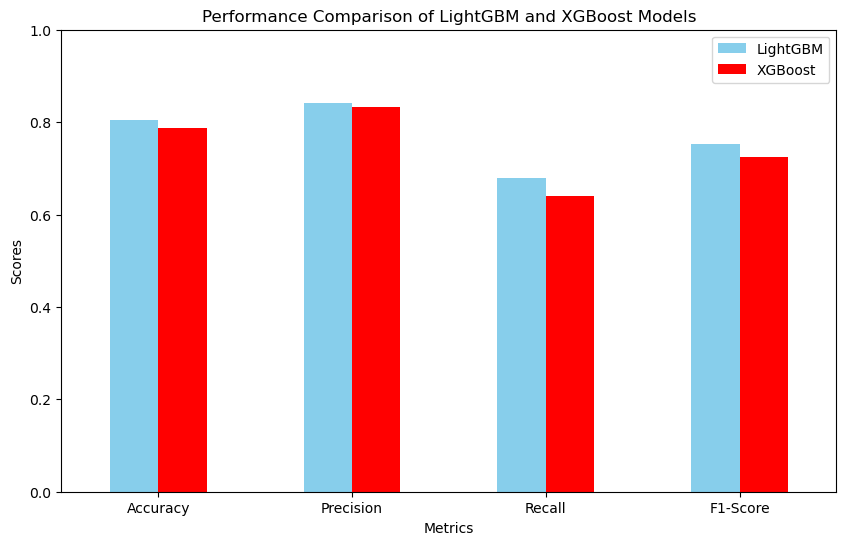

In [302]:
#  Plot the comparison
metrics_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'RED'])
plt.title("Performance Comparison of LightGBM and XGBoost Models")
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="best")
plt.show()

In [ ]:
# 2.Visualize and interpret the results to identify the strengths and weaknesses of each algorithm.

# -----THE END-----